# Klasifikasi Stress EEG dengan Seleksi Channel

In [ ]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras  


import variables as v
import dataset
import features
import classifiers
import genetic_algrthm as ga

In [2]:
PATH_DATA_MENTAH = "Data/raw_data"
PATH_FILE_LOCS = v.CHANNELS_PATH
PATH_FILE_LABEL = v.LABELS_PATH

In [3]:
# Memuat data mentah dari semua 32 channel
full_dataset = dataset.load_dataset(data_type="raw", test_type="Arithmetic")
# Memuat daftar nama dari 32 channel tersebut dari file .locs
all_channels_list = dataset.load_channels()
print(f"Berhasil memuat dataset dengan {full_dataset.shape[1]} channel.")
print(f"Bentuk data: {full_dataset.shape}")
print(f"Daftar channel yang dimuat: {all_channels_list}")

Berhasil memuat dataset dengan 32 channel.
Bentuk data: (120, 32, 3200)
Daftar channel yang dimuat: ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']


## Channel Selection

In [4]:
# Pengaturan untuk Algoritma Genetika
ga_parameters = {
    "num_generations": 10,
    "num_parents_mating": 5,
    "num_people_in_pop": 15,
    "num_channels_to_select": 8
}

# Mempersiapkan label yang dibutuhkan
raw_labels_df = dataset.load_labels()
# Asumsi 12 epoch per trial berdasarkan data Anda
num_epochs_per_trial = 12
labels_for_ga = dataset.format_labels(
    raw_labels_df, test_type="Arithmetic", epochs=num_epochs_per_trial)

print("\n--- Langkah 2: Menjalankan Algoritma Genetika untuk Seleksi Channel ---")
# Menjalankan seluruh proses dengan satu panggilan fungsi
selected_channels = ga.run_channel_selection(
    full_dataset=full_dataset,
    all_channels_list=all_channels_list,
    labels_for_ga=labels_for_ga,
    ga_params=ga_parameters
)


--- Langkah 2: Menjalankan Algoritma Genetika untuk Seleksi Channel ---
  -> Generasi 1/10...
     -> Ditemukan solusi terbaik baru dengan fitness 2.22
     -> Channel: ['Fp2' 'FT10' 'P3' 'C4' 'FC2' 'CP6' 'FC5' 'CP5']
  -> Generasi 2/10...
  -> Generasi 3/10...
     -> Ditemukan solusi terbaik baru dengan fitness 2.26
     -> Channel: ['F4' 'CP1' 'F7' 'CP5' 'Fp2' 'FT10' 'P3' 'C4']
  -> Generasi 4/10...
  -> Generasi 5/10...
  -> Generasi 6/10...
  -> Generasi 7/10...
  -> Generasi 8/10...
  -> Generasi 9/10...
  -> Generasi 10/10...

--- Seleksi Channel Selesai ---
Channel terbaik yang ditemukan: ['F4', 'CP1', 'F7', 'CP5', 'Fp2', 'FT10', 'P3', 'C4']


In [5]:
# Filter dataset untuk hanya menyertakan channel yang terpilih
Data = ga.get_subset(
    data=full_dataset,
    all_genes=all_channels_list,
    subset_genes=selected_channels
)

print(f"\nChannel yang terpilih: {selected_channels}")
print(f"Bentuk data setelah seleksi channel: {Data.shape}")


Channel yang terpilih: ['F4', 'CP1', 'F7', 'CP5', 'Fp2', 'FT10', 'P3', 'C4']
Bentuk data setelah seleksi channel: (120, 8, 3200)


Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Using matplotlib as 2D backend.


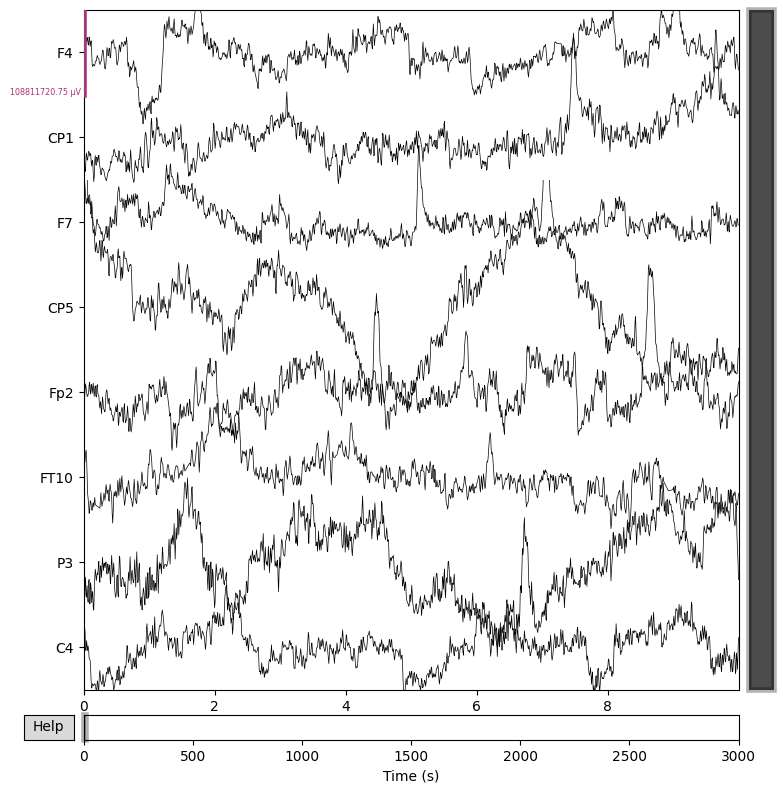

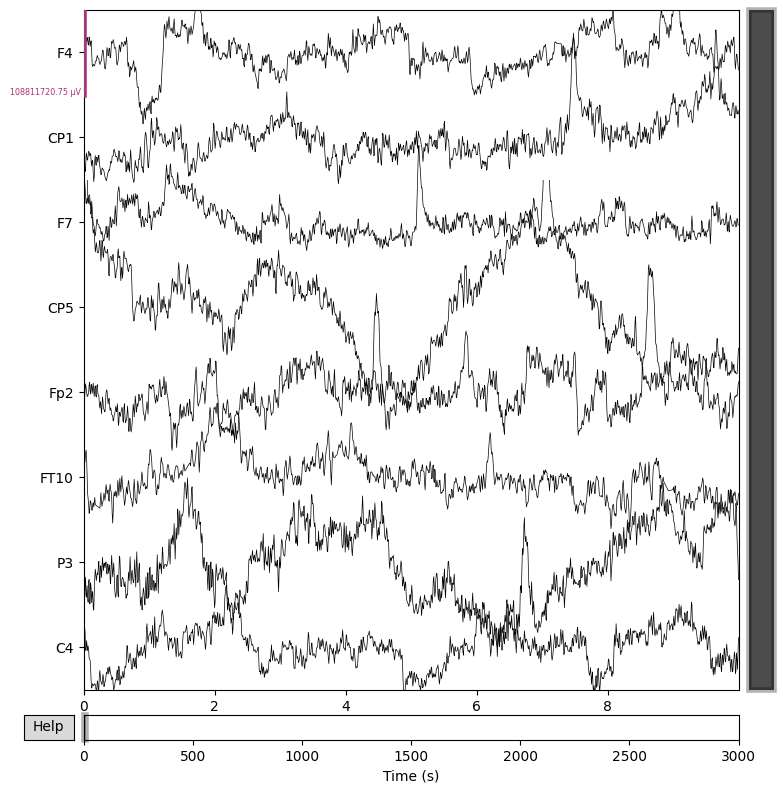

In [6]:
n_trials, n_channels, n_samples_per_trial = Data.shape
visdata = Data.reshape(n_channels, n_trials * n_samples_per_trial)

ch_names = selected_channels
ch_types = ['eeg'] * n_channels
sfreq = v.SFREQ  # Ambil frekuensi sampling dari file variables.py

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 3. Buat objek MNE RawArray dari data NumPy dan Info
mne_object = mne.io.RawArray(visdata, info)

# 4. Plot sinyal menggunakan fungsi bawaan MNE
#    'n_channels' -> berapa channel yang ditampilkan sekaligus
#    'duration' -> berapa detik data yang ditampilkan per layar
#    'scalings' -> mengatur skala plot agar sinyal terlihat jelas
mne_object.plot(n_channels=8, duration=10, scalings='auto')

In [7]:
all_types_to_load = v.TRIAL_TYPES + v.BASELINE_TYPE

mne_objects_dict = {}

for data_type in all_types_to_load:
    temp_full_dataset = dataset.load_dataset(
        data_type = 'raw', test_type=data_type)
    temp_channels_selection = ga.get_subset(
        data=temp_full_dataset,
        all_genes=all_channels_list,
        subset_genes=selected_channels
    )

    n_trials, n_channels, n_samples = temp_channels_selection.shape
    data_for_mne = temp_channels_selection.reshape(
        n_channels, n_trials * n_samples)
    
    info = mne.create_info(
        ch_names=selected_channels,
        sfreq=v.SFREQ,
        ch_types=['eeg'] * len(selected_channels)
        )
    
    mne_objects_dict[data_type] = mne.io.RawArray(data_for_mne, info)

print(f'{len(mne_objects_dict)} jenis data telah dimuat ke dalam dictionary mne_objects_dict.')


    

Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
4 jenis data telah dimuat ke dalam dictionary mne_objects_dict.


## Decomposed Data & Differential Entropy


In [8]:
decomposed_data = features.decompose_to_bands(mne_objects_dict)

de_features = features.differential_entropy_features(decomposed_data)
if de_features:
    print(
        f"Task yang berhasil diekstrak fiturnya: {list(de_features.keys())}")
    first_key = list(de_features.keys())[0]
    print(
        f"Bentuk vektor fitur untuk '{first_key}': {de_features[first_key].shape}")

Task yang berhasil diekstrak fiturnya: ['Arithmetic', 'Mirror', 'Stroop']
Bentuk vektor fitur untuk 'Arithmetic': (32,)


Menampilkan visualisasi sinyal per band untuk task: Arithmetic

--- Visualisasi untuk Band: Theta ---


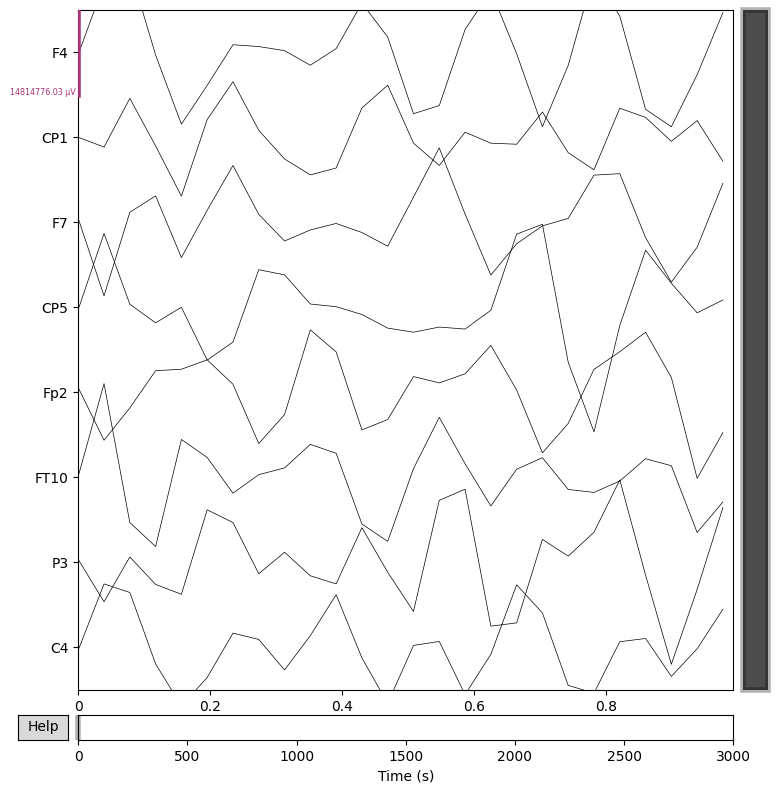


--- Visualisasi untuk Band: Alpha ---


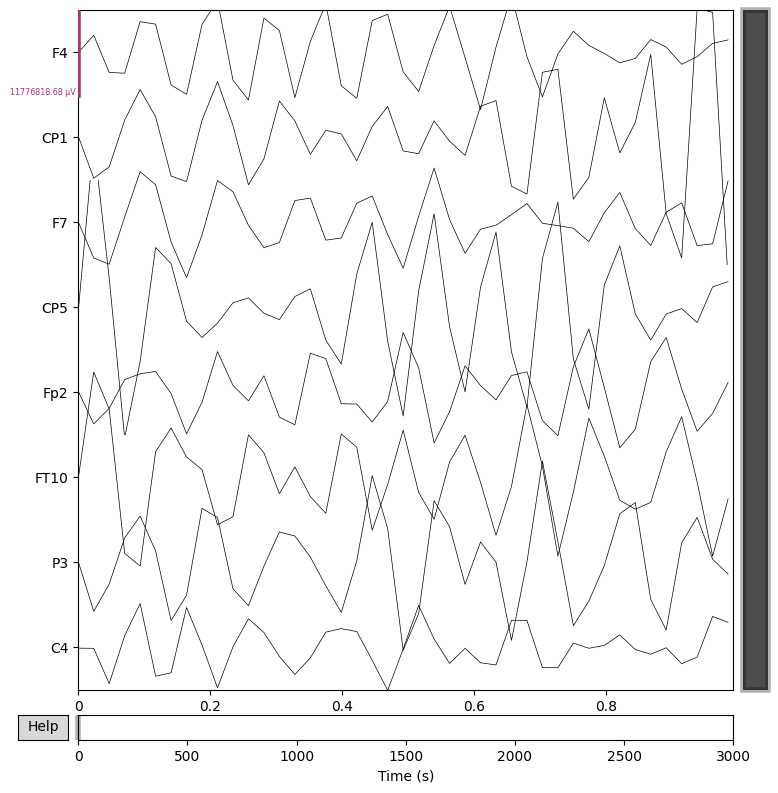


--- Visualisasi untuk Band: Beta ---


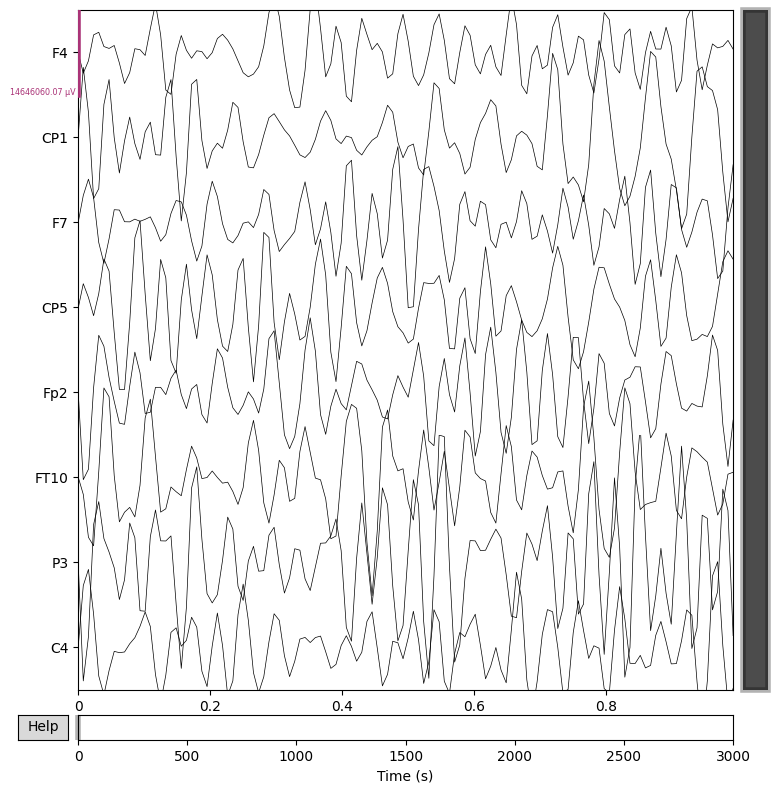


--- Visualisasi untuk Band: Gamma ---


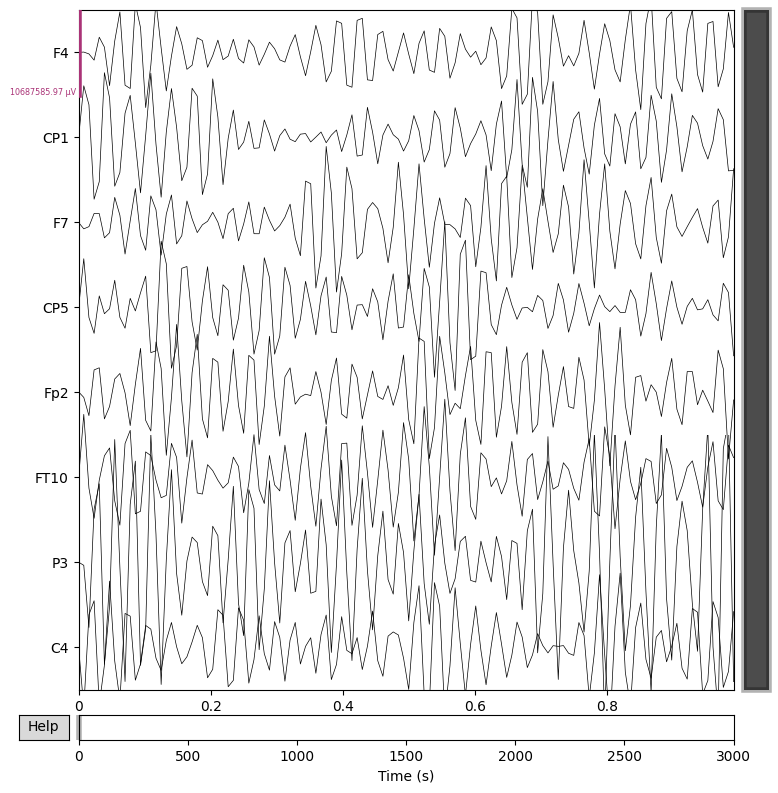

In [9]:
# Tentukan task mana yang ingin Anda lihat visualisasinya
task_to_visualize = 'Arithmetic'
# Tentukan urutan band
band_order = ['Theta', 'Alpha', 'Beta', 'Gamma']

print(
    f"Menampilkan visualisasi sinyal per band untuk task: {task_to_visualize}")

# Loop untuk setiap nama band
for band_name in band_order:
    print(f"\n--- Visualisasi untuk Band: {band_name} ---")

    # 1. Akses objek MNE untuk task dan band yang spesifik
    mne_band_object = decomposed_data[task_to_visualize][band_name]

    # 2. Panggil fungsi .plot() pada objek tersebut
    #    Plot akan muncul satu per satu untuk setiap band
    mne_band_object.plot(n_channels=8, duration=1, scalings='auto')

## 3D Cube

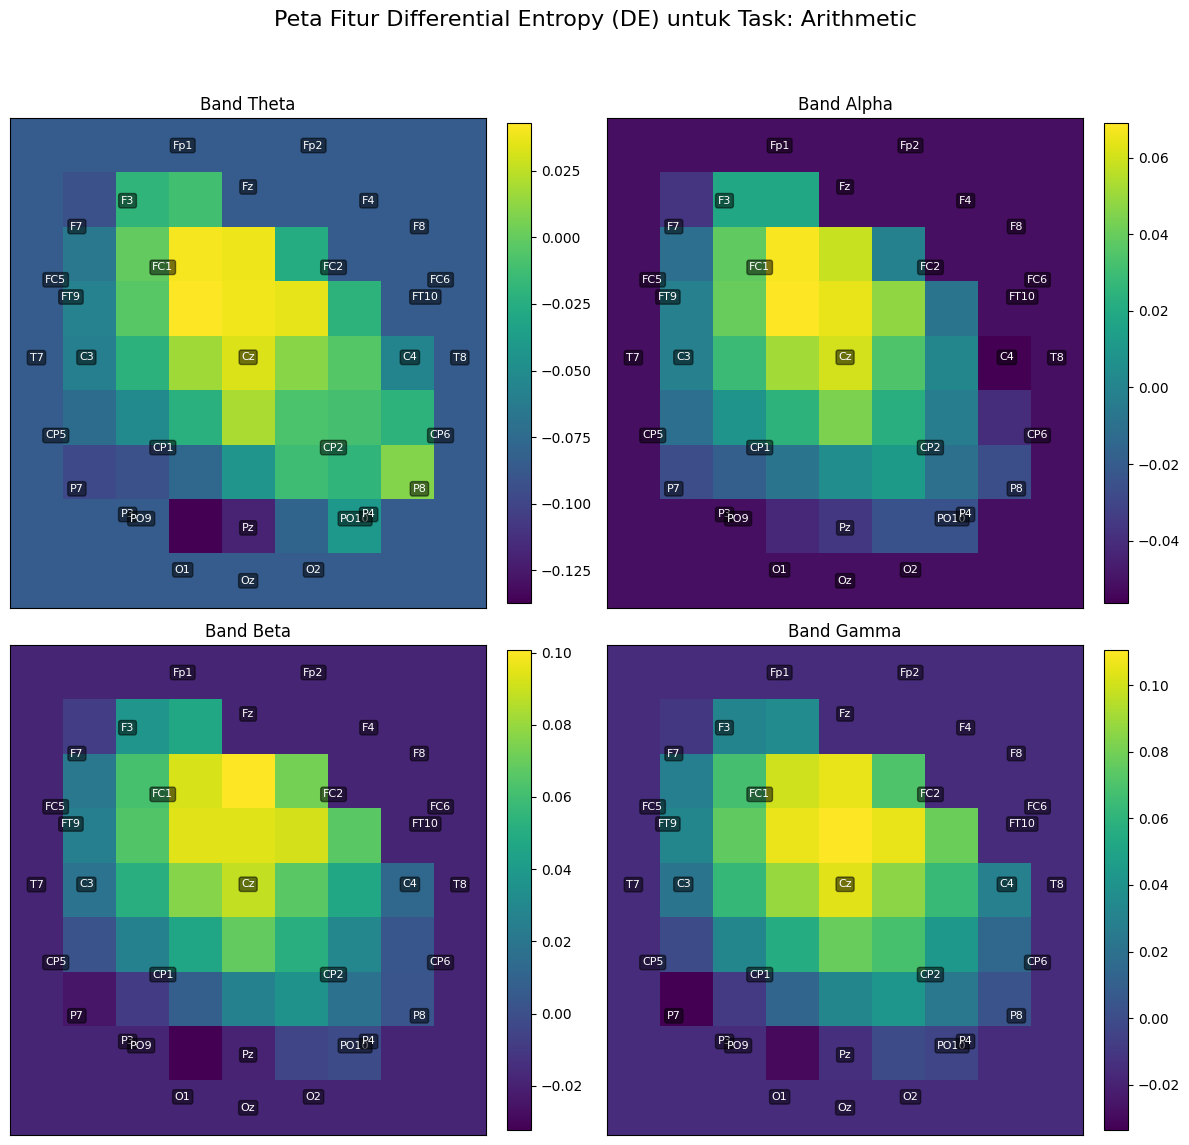

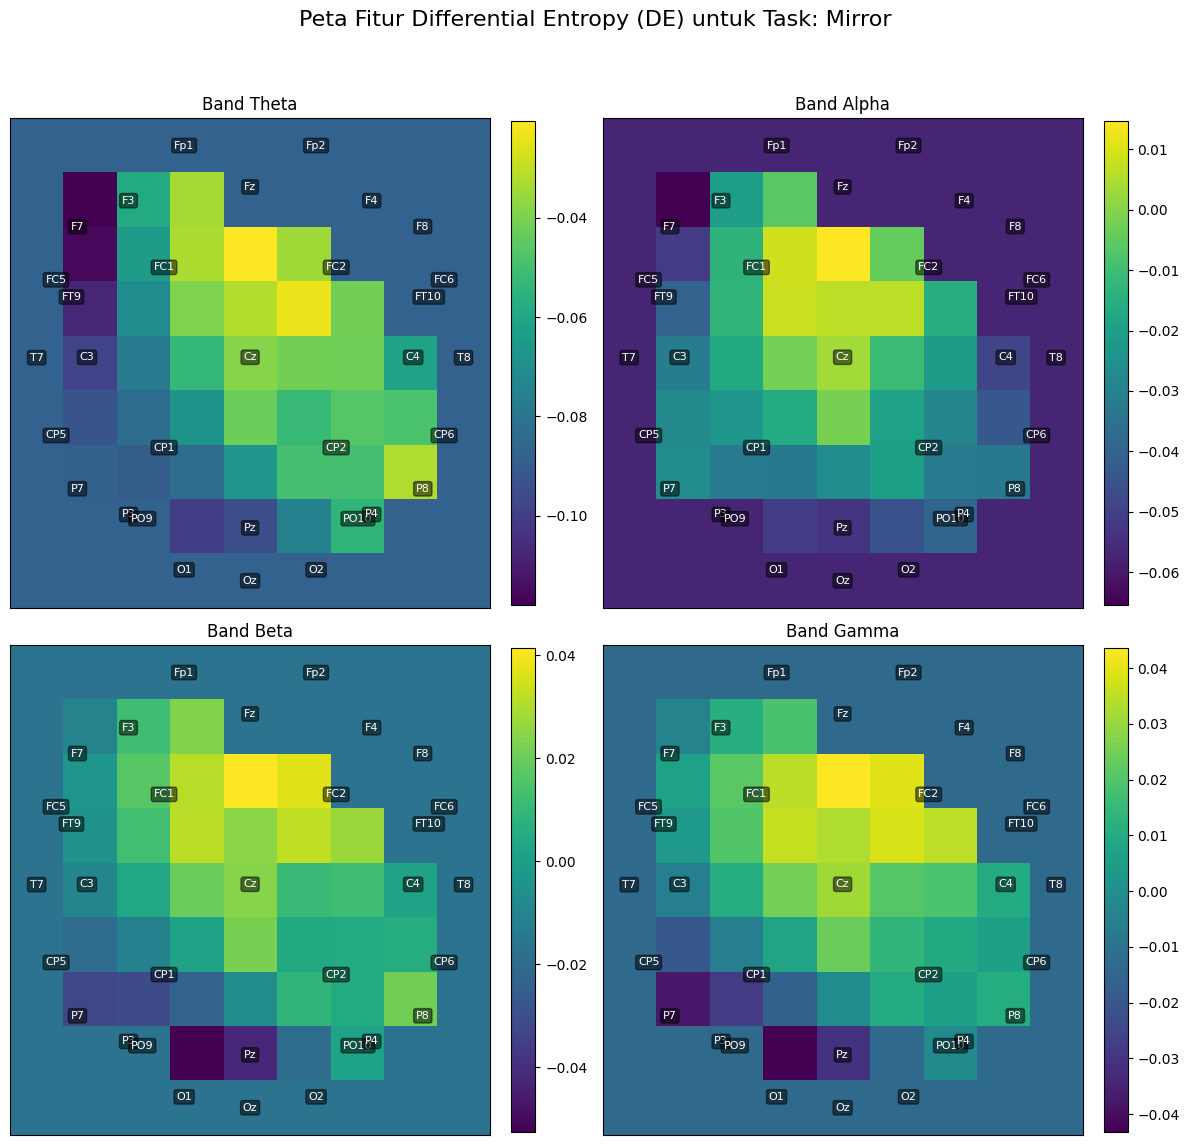

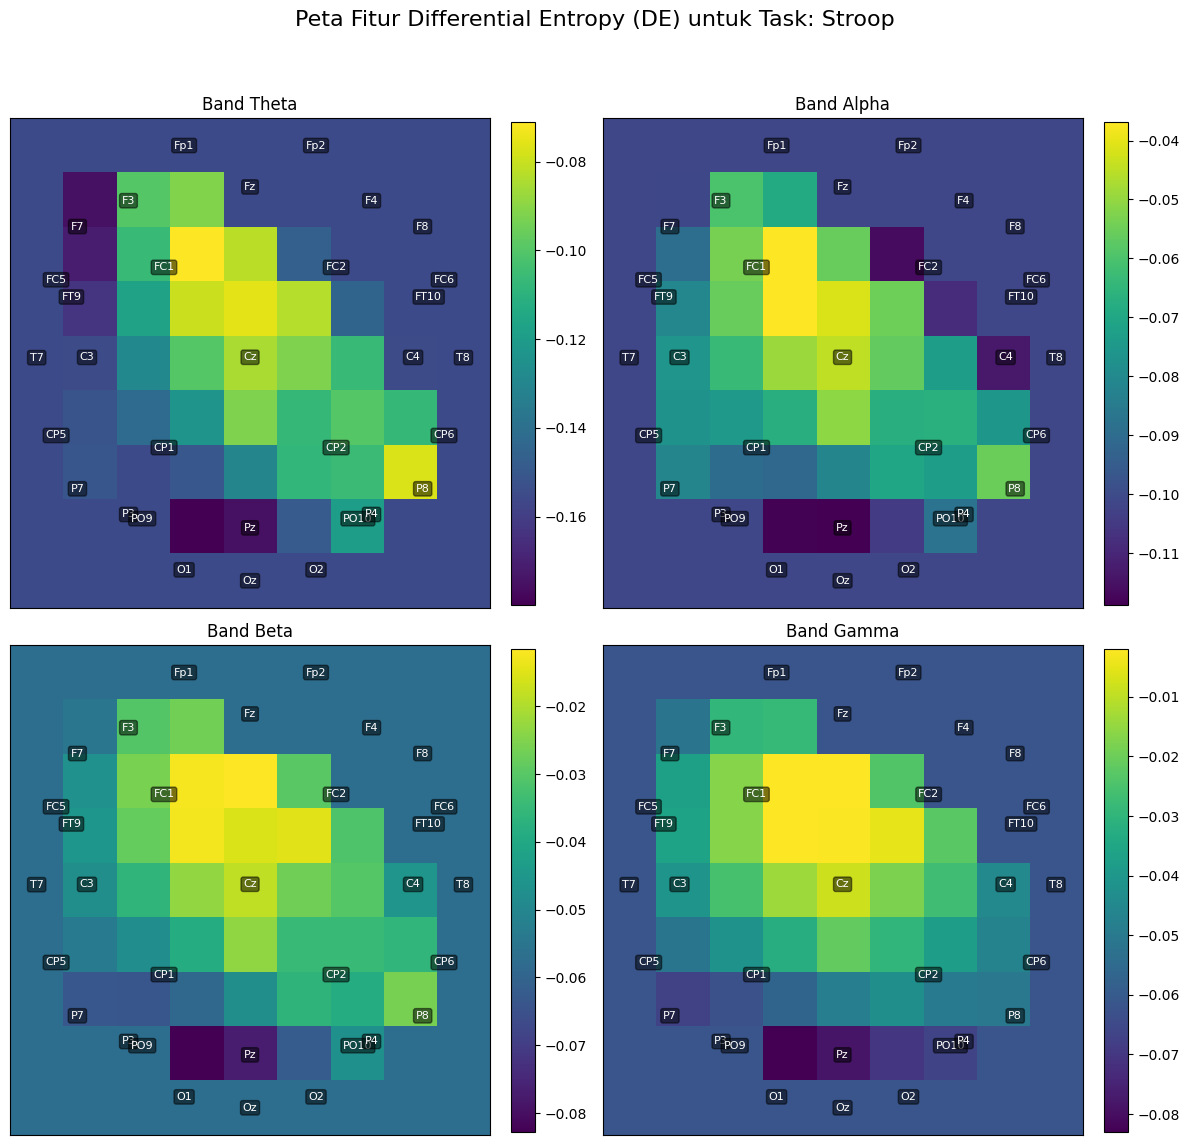

In [10]:
feature_maps_3d = features.create_3d_feature_maps(
    feature_vectors_dict=de_features,
    montage_path=v.CHANNELS_PATH,
    selected_channels_list=selected_channels
    )

for task_name, feature_map in feature_maps_3d.items():
    features.visualize_3d_feature_map(
        feature_map,
        montage_path=v.CHANNELS_PATH,
        title=f"Peta Fitur Differential Entropy (DE) untuk Task: {task_name}"
    )

## Classification

### CCN

In [11]:
# Menggabungkan semua data task menjadi satu untuk diproses
all_task_data_list = []
for task_name in ["Arithmetic", "Mirror", "Stroop"]:
    temp_full_dataset = dataset.load_dataset(
        data_type="raw", test_type=task_name)
    temp_data_terseleksi = ga.get_subset(
        data=temp_full_dataset,
        all_genes=all_channels_list,
        subset_genes=selected_channels
    )
    all_task_data_list.append(temp_data_terseleksi)

# Menggabungkan data dari 3 task menjadi satu array besar (360, 8, 3200)
X_raw_selected = np.concatenate(all_task_data_list, axis=0)

# Mengubah data mentah menjadi epoch. Asumsi 2 detik per epoch.
# 3200 sampel / (128 Hz * 2 detik) = 12.5 -> 12 epoch per trial
epoched_data = dataset.convert_to_epochs(
    X_raw_selected, n_genes=len(selected_channels), sfreq=v.SFREQ)
# Bentuk output: (360 * 12, 8, 256)

# Ekstrak fitur Hjorth dari setiap epoch
X_features = features.hjorth_features(epoched_data)
# Bentuk output: (4320, 24) -> 4320 sampel, 24 fitur (8 channel * 3 fitur Hjorth)
print(f"Ekstraksi fitur selesai. Bentuk X: {X_features.shape}")


labels_df = dataset.load_labels()
# Mendapatkan label untuk semua 3 task dan ulangi untuk setiap epoch
num_epochs = epoched_data.shape[0] // X_raw_selected.shape[0]  # -> 12
y_binary = []
for task_name in ["Arithmetic", "Mirror", "Stroop"]:
    labels_for_task = dataset.format_labels(
        labels_df, test_type=task_name, epochs=num_epochs)
    y_binary.append(labels_for_task)

y_binary = np.concatenate(y_binary, axis=0)

# Ubah ke one-hot encoding
y = to_categorical(y_binary, num_classes=2)
print(f"Persiapan label selesai. Bentuk y: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Bentuk X_train: {X_train.shape}, Bentuk y_train: {y_train.shape}")



input_size = X_train.shape[1]  # -> 24
output_size = y_train.shape[1]  # -> 2

model_nn = classifiers.NN(
    input_size=input_size, output_size=output_size,
    num_layers=3, num_neurons=[64, 32, 16], dropout_rate=0.3
)
model_nn.compile(optimizer='adam',
                 loss='categorical_crossentropy', metrics=['accuracy'])

print("\nMemulai pelatihan model NN...")
history = model_nn.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("\n--- Mengevaluasi Performa Model ---")
loss, accuracy = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi final pada data test: {accuracy:.2%}")



Ekstraksi fitur selesai. Bentuk X: (4320, 24)
Persiapan label selesai. Bentuk y: (4320, 2)
Bentuk X_train: (3456, 24), Bentuk y_train: (3456, 2)

Memulai pelatihan model NN...
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5178 - loss: 41.1474 - val_accuracy: 0.5532 - val_loss: 16.6481
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5722 - loss: 12.2301 - val_accuracy: 0.5683 - val_loss: 9.0613
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5666 - loss: 14.9617 - val_accuracy: 0.5197 - val_loss: 10.9202
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5530 - loss: 8.1042 - val_accuracy: 0.5787 - val_loss: 7.4489
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5979 - loss: 4.2047 - val_accuracy: 0.5012 - val_loss: 15.5547
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6055 - loss: 8.8460 - val_accuracy: 0.6227 - val_loss: 6.1885
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


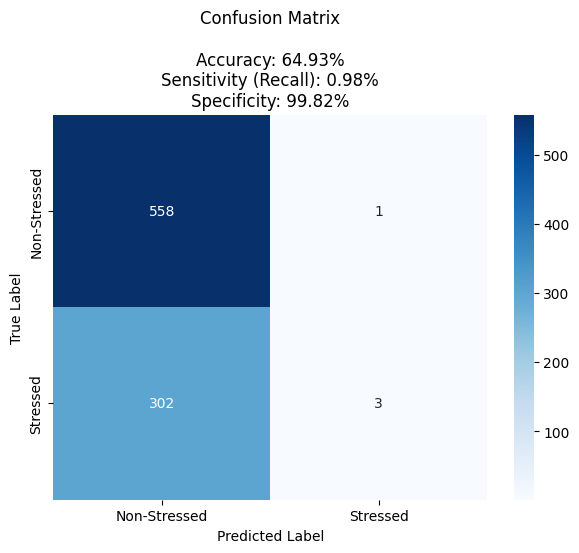


Laporan Klasifikasi Rinci:
              precision    recall  f1-score   support

Non-Stressed       0.65      1.00      0.79       559
    Stressed       0.75      0.01      0.02       305

    accuracy                           0.65       864
   macro avg       0.70      0.50      0.40       864
weighted avg       0.68      0.65      0.52       864



In [12]:
import metrics

y_pred_prob = model_nn.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
metrics.plot_conf_matrix_and_stats(conf_matrix, class_names=[
                                   'Non-Stressed', 'Stressed'])

### NN

Model NN berhasil di-compile.

Memulai pelatihan model NN...
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5515 - loss: 82.5291 - val_accuracy: 0.5521 - val_loss: 14.9538
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5816 - loss: 18.9092 - val_accuracy: 0.6262 - val_loss: 18.2644
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5880 - loss: 18.9121 - val_accuracy: 0.4757 - val_loss: 18.1611
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5687 - loss: 12.8424 - val_accuracy: 0.5995 - val_loss: 7.0525
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6161 - loss: 7.7820 - val_accuracy: 0.6042 - val_loss: 8.8409
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 8.6351 - val_accuracy: 0.5509 - val_loss: 13.5368
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5859 - loss: 7.7584 - val_accuracy: 0.4734 - val_loss: 8.9401
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━

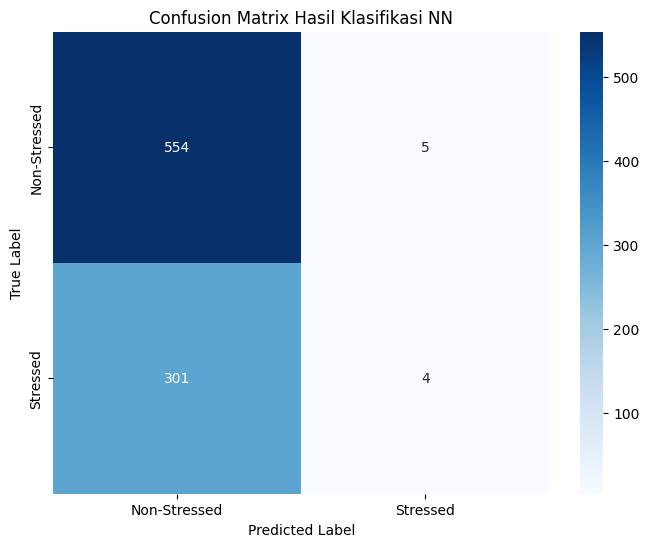


Laporan Klasifikasi Rinci:
              precision    recall  f1-score   support

Non-Stressed       0.65      0.99      0.78       559
    Stressed       0.44      0.01      0.03       305

    accuracy                           0.65       864
   macro avg       0.55      0.50      0.40       864
weighted avg       0.58      0.65      0.52       864



In [13]:
input_size = X_train.shape[1]  # Ini akan menjadi 32
output_size = y_train.shape[1]  # Ini akan menjadi 2

model_nn = classifiers.NN(
    input_size=input_size,
    output_size=output_size,
    num_layers=3,
    num_neurons=[64, 32, 16],  # Neuron untuk setiap dari 3 layer
    dropout_rate=0.3
)
model_nn.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
print("Model NN berhasil di-compile.")


# 3. Melatih Model
print("\nMemulai pelatihan model NN...")
history = model_nn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# 4. Evaluasi Model pada Data Uji
print("\n--- Mengevaluasi Performa Model ---")
loss, accuracy = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi final pada data test: {accuracy:.2%}")

# 5. Membuat Prediksi dan Visualisasi Hasil
# Dapatkan probabilitas prediksi dari model
y_pred_prob = model_nn.predict(X_test)
# Ubah probabilitas (misal: [0.1, 0.9]) menjadi label kelas (0 atau 1)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
# Ubah y_test dari one-hot (misal: [0, 1]) menjadi label kelas tunggal
y_true_classes = np.argmax(y_test, axis=1)

# Buat dan plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_names = ['Non-Stressed', 'Stressed']  # Kelas 0 dan 1

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Hasil Klasifikasi NN')
plt.show()

# Tampilkan laporan klasifikasi yang lebih rinci
print("\nLaporan Klasifikasi Rinci:")
print(classification_report(y_true_classes, y_pred_classes,
      target_names=class_names, zero_division=0))

### SVM

In [ ]:
y_train_svm = np.argmax(y_train, axis=1)
y_test_svm = np.argmax(y_test, axis=1)

print(f"Bentuk label telah disesuaikan untuk SVM: {y_train_svm.shape}")

# 2. Panggil fungsi svm_classification yang sudah ada
#    Fungsi ini akan menangani scaling, grid search, training, dan evaluasi
classifiers.svm_classification(
    train_data=X_train,
    test_data=X_test,
    train_labels=y_train_svm,
    test_labels=y_test_svm
)

Bentuk label telah disesuaikan untuk SVM: (3456,)
